# MNIST Image Classification with TensorFlow on Cloud ML Engine

This notebook demonstrates how to implement different image models on MNIST using Estimator. 

Note the MODEL_TYPE; change it to try out different models

In [1]:
import os
PROJECT = "qwiklabs-gcp-00-33b6385f2fbc" # REPLACE WITH YOUR PROJECT ID
BUCKET = "qwiklabs-gcp-00-33b6385f2fbc" # REPLACE WITH YOUR BUCKET NAME
REGION = "us-east1" # REPLACE WITH YOUR BUCKET REGION e.g. us-central1
MODEL_TYPE = "cnn"  # "linear", "dnn", "dnn_dropout", or "cnn"

# Do not change these
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION
os.environ["MODEL_TYPE"] = MODEL_TYPE
os.environ["TFVERSION"] = "1.13"  # Tensorflow version

In [2]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


## Run as a Python module

In the previous notebook (mnist_linear.ipynb) we ran our code directly from the notebook.

Now since we want to run our code on Cloud ML Engine, we've packaged it as a python module.

The `model.py` and `task.py` containing the model code is in <a href="mnistmodel/trainer">mnistmodel/trainer</a>

**Complete the TODOs in `model.py` before proceeding!**

Once you've completed the TODOs, set MODEL_TYPE and run it locally for a few steps to test the code.

In [3]:
%%bash
rm -rf mnistmodel.tar.gz mnist_trained
gcloud ai-platform local train \
    --module-name=trainer.task \
    --package-path=${PWD}/mnistmodel/trainer \
    -- \
    --output_dir=${PWD}/mnist_trained \
    --train_steps=100 \
    --learning_rate=0.01 \
    --model=$MODEL_TYPE

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting mnist/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting mnist/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist/data/t10k-labels-idx1-ubyte.gz





Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Instructions for updating:
Please use tf.data to implement this functionality.
Instructions for updating:
Please use tf.data to implement this functionality.
Instructions for updating:
Please use tf.one_hot on tensors.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


INFO:tensorflow:TF_CONFIG environment variable: {u'environment': u'cloud', u'cluster': {}, u'job': {u'args': [u'--output_dir=/home/jupyter/training-data-analyst/courses/machine_learning/deepdive/08_image/labs/mnist_trained', u'--train_steps=100', u'--learning_rate=0.01', u'--model=cnn'], u'job_name': u'trainer.task'}, u'task': {}}
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_sec

**Now, let's do it on Cloud ML Engine so we can train on GPU:** `--scale-tier=BASIC_GPU`

Note the GPU speed up depends on the model type. You'll notice the more complex CNN model trains significantly faster on GPU, however the speed up on the simpler models is not as pronounced.

In [4]:
%%bash
OUTDIR=gs://${BUCKET}/mnist/trained_${MODEL_TYPE}
JOBNAME=mnist_${MODEL_TYPE}_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ai-platform jobs submit training $JOBNAME \
    --region=$REGION \
    --module-name=trainer.task \
    --package-path=${PWD}/mnistmodel/trainer \
    --job-dir=$OUTDIR \
    --staging-bucket=gs://$BUCKET \
    --scale-tier=BASIC_GPU \
    --runtime-version=$TFVERSION \
    -- \
    --output_dir=$OUTDIR \
    --train_steps=10000 --learning_rate=0.01 --train_batch_size=512 \
    --model=$MODEL_TYPE --batch_norm

gs://qwiklabs-gcp-00-33b6385f2fbc/mnist/trained_cnn us-east1 mnist_cnn_200224_230353
jobId: mnist_cnn_200224_230353
state: QUEUED


CommandException: 1 files/objects could not be removed.
Job [mnist_cnn_200224_230353] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe mnist_cnn_200224_230353

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs mnist_cnn_200224_230353


## Monitor training with TensorBoard

To activate TensorBoard within the JupyterLab UI navigate to "<b>File</b>" - "<b>New Launcher</b>".   Then double-click the 'Tensorboard' icon on the bottom row.

TensorBoard 1 will appear in the new tab.  Navigate through the three tabs to see the active TensorBoard.   The 'Graphs' and 'Projector' tabs offer very interesting information including the ability to replay the tests.

You may close the TensorBoard tab when you are finished exploring.

## Deploying and predicting with model

Deploy the model:

In [5]:
%%bash
MODEL_NAME="mnist"
MODEL_VERSION=${MODEL_TYPE}
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/mnist/trained_${MODEL_TYPE}/export/exporter | tail -1)
echo "Deleting and deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"
#gcloud ai-platform versions delete ${MODEL_VERSION} --model ${MODEL_NAME}
#gcloud ai-platform models delete ${MODEL_NAME}
gcloud ai-platform models create ${MODEL_NAME} --regions $REGION
gcloud ai-platform versions create ${MODEL_VERSION} --model ${MODEL_NAME} --origin ${MODEL_LOCATION} --runtime-version=$TFVERSION

Deleting and deploying mnist cnn from gs://qwiklabs-gcp-00-33b6385f2fbc/mnist/trained_cnn/export/exporter/1582585635/ ... this will take a few minutes


Created ml engine model [projects/qwiklabs-gcp-00-33b6385f2fbc/models/mnist].
Creating version (this might take a few minutes)......
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

To predict with the model, let's take one of the example images.

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

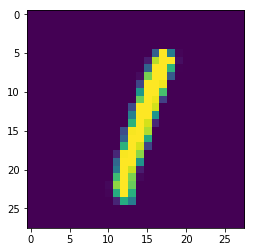

In [6]:
import json, codecs
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

HEIGHT = 28
WIDTH = 28

mnist = input_data.read_data_sets("mnist/data", one_hot = True, reshape = False)
IMGNO = 5 #CHANGE THIS to get different images
jsondata = {"image": mnist.test.images[IMGNO].reshape(HEIGHT, WIDTH).tolist()}
json.dump(jsondata, codecs.open("test.json", "w", encoding = "utf-8"))
plt.imshow(mnist.test.images[IMGNO].reshape(HEIGHT, WIDTH));

Send it to the prediction service

In [ ]:
%%bash
gcloud ai-platform predict \
    --model=mnist \
    --version=${MODEL_TYPE} \
    --json-instances=./test.json

<pre>
# Copyright 2017 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
</pre>